In [1]:
%matplotlib notebook

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.experiment_container import load_experiment_by_name, new_experiment
import qcodes_measurements as qcm

import numpy as np
from IPython.display import Image

## Using a monitor

Open a command promt window and type

*activate qcodes_master* 

*python –m qcodes.monitor.monitor*

### Define a new experiment

In [2]:
exp_name = 'QDP_FIVEDOT'
sample_name = 'DEMO1'

try:
    exp = load_experiment_by_name(exp_name, sample=sample_name)
    print('Experiment loaded. Last ID no:', exp.last_counter)
except ValueError:
    exp = new_experiment(exp_name, sample_name)
    print('Starting new experiment.')

Experiment loaded. Last ID no: 2


All data taken will be saved in (ideally) one single database file. Qcodes will save all data in the .db file specified in the qcodes config file `qcodesrc.json`. There are several places that this can be set:
 1. In the working directory (same place directory the notebooks are being run from)
 2. In your home directory (`C:\Users\experimental\qcodesrc.json` or similar)
 3. The qcodes package - don't change it here.

If the cell below says "./experiments.db", then the default has not been overwritten. If it says something else, then someone has changed the default database location. Please do not change it unless you really want to save data at different locations.

In [3]:
qc.config['core']['db_location']

'C:\\Users\\Administrator\\Documents\\Experiments\\experiments.db'

# Option Stationconfigurator

What you will need is a .yaml file, you find a template in the same folder as this notebook

In [4]:
from qdev_wrappers.station_configurator import StationConfigurator

In [5]:
my_config_file = 'system1.yaml'
scfg = StationConfigurator(my_config_file)

In [6]:
# Instantiate some instruments:

mdac = scfg.load_instrument('mdac')
lockin = scfg.load_instrument('sr860')
dso = scfg.load_instrument('dso')
qubit_source = scfg.load_instrument('qubit_source')

C:\Users\Administrator\Anaconda3\envs\qcodes_master\lib\site-packages\pyvisa\ctwrapper\functions.py:1649: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return library.viSetAttribute(session, attribute, attribute_state)


Connected to: QNL Sydney MDAC (serial:0x32353532353551040032003E, firmware:1.4) in 2.63s
Connected to: Stanford_Research_Systems SR860 (serial:003121, firmware:V1.47) in 0.10s
Connected to: KEYSIGHT TECHNOLOGIES MSOS254A (serial:MY57220131, firmware:06.10.00616) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110571, firmware:3.1.19.15-3.50.124.67) in 0.03s


### Using the mdac

We have to choose whether we connect to the fridge directly via the MicroD outputs on the MDAC, or whether we go via the front panel SMCs. Each method has advantages and disadvatages:

### Through the Micro-D's
 - No additional breakout box required.
 - All measurements can be configured without physically changing any switches or connections. We can operate the experiment fully from the computer.
 - Lockin or through measurements can be configured and changed without rewiring. Use the divider and sine/DC output of the MDAC as the signal, and connect the lockin or ithaco to the bus line.
   - Alternatively we just use the front SMC's as the connections down the fridge. Useful if for example we want to use the lockin output, or many lockins.
 - Biases can be applied without requiring a bus mode on the breakout box.
However there is the downside that the DAC mapping is fixed.

### Through the SMC's
 - We can use any mapping we want on the MDAC. Useful if lines are distributed over more than 2 MicroDs.
 - It is possible to disconnect the MDAC during an experiment without floating the device.
 
### Automating setup
There is also code in the module to automatically set things up if you are running through the MicroDs.
 - **OHMICS**: Ohmic contacts
 - **GATES**: DC Bias gates
 - **SHORTS**: Shorted DC Pairs, used for checking line resistances/mappings
Note: Setup assumes that all gates up to `microd_high` run through the micro_d, any lines higher than `microd_high` are then connected to the smc. 

⚠️ **IMPORTANT**: Only run this code when starting the experiment, as output connections can only be changed when the dac outputs are zero. ⚠️

In [7]:
mdac.ch08.voltage(0)
mdac.ch08.rate(0.05) # 50mV/s ramp rate
mdac.ch08.dac_output('close')
mdac.ch08.gnd('open')

# If we want to connect to the fridge via the SMC connectors on the MDAC
mdac.ch08.smc('close')  # front panel

# If we want to connect to the fridge directly via the micro-D outputs
# mdac.ch08.microd('close')  # fridge

# Or we can automate setup through the MicroD's

# Set up gate sets
OHMICS_NUMS = (x-1 for x in (41, 28, 15))
GATES_MDAC_NUMS = (x-1 for x in (12, 31, 45, 1, 39))
GATES_BB_NUMS = tuple(x-1 for x in range(48, 65))
SHORTS_NUMS = (x-1 for x in (37, 11, 33, 44, 20, 19, 4, 3, 14, 25, 43, 30))

OHMICS = qcm.make_channel_list(mdac, "Dev_Ohmics", OHMICS_NUMS)
GATES_MDAC = qcm.make_channel_list(mdac, "Dev_Gates", GATES_MDAC_NUMS)
GATES_BB = qcm.make_channel_list(mdac, "Dev_Gates", GATES_BB_NUMS)
GATES = GATES_MDAC + GATES_BB
GATES.rate(0.05)

# Only run the below line when starting your experiment
#qcm.setup(mdac, OHMICS, GATES_MDAC, SHORTS_MDAC, microd_high=48)

c:\users\administrator\documents\qcodes\qcodes\instrument\parameter.py:1141: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


In [8]:
# Set voltage:
mdac.ch08.voltage(0.1)

# ramp voltage:
mdac.ch08.ramp(0)

### Running Measurements

qcodes_measurements defines some functions for doing simple 1D and 2D sweeps, which will live-plot the data as it is coming in. These functions are reminscent of do1d/do2d to those who are old enough to remember those.

⚠️ **IMPORTANT**: When running measurements using these functions, parameters are set, so if you have sensitive gates, make sure that you define `parameter.step` and `parameter.inter_delay` for the parameters that you want to use.

#### Running 1D Traces
This will open a pyqtgraph window that will stream the data as it comes in. Once the trace is done the figure will be saved to the figures folder. We can include it in the notebook as well if we like.

**Note**: There are a large number of optional arguments that can be passed to linear1d which change how the function works. See the docstring for more info...

sr860_X_current mdac_chan8_voltage
Starting experimental run with id: 4511
Saving to: C:\Users\Administrator\Documents\qcodes_measurements\templates\figures\4511.png


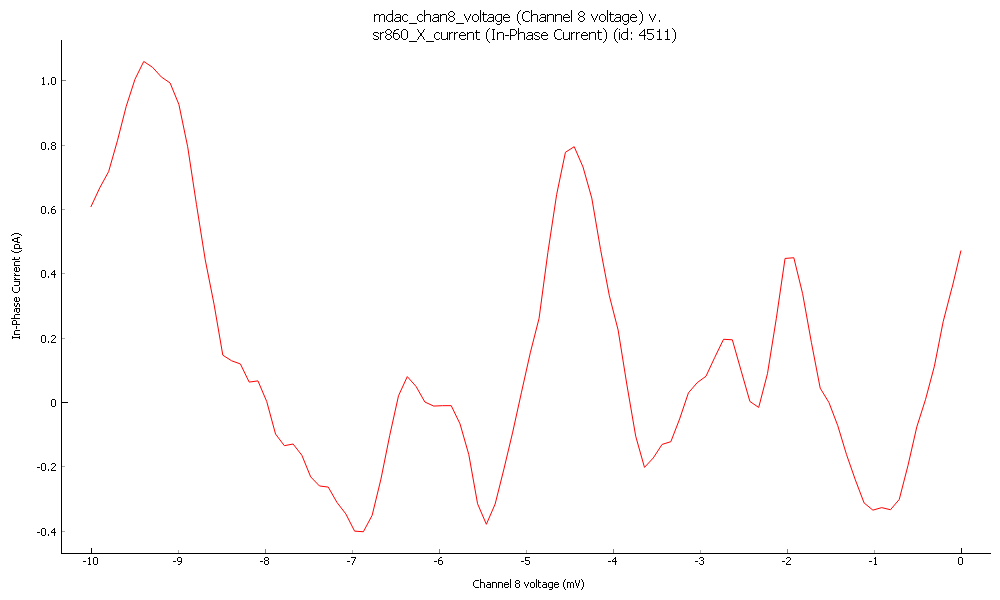

In [9]:
dataid, win = qcm.linear1d(mdac.ch08.voltage, 0, -0.01, 100, 0.001, lockin.X_current)
Image(f"figures\\{dataid}.png", width=600)

#### Running 2D Traces
Similarly we can run 2D traces where we sweep two parameters.

Starting experimental run with id: 4512
Saving to: C:\Users\Administrator\Documents\qcodes_measurements\templates\figures\4512.png


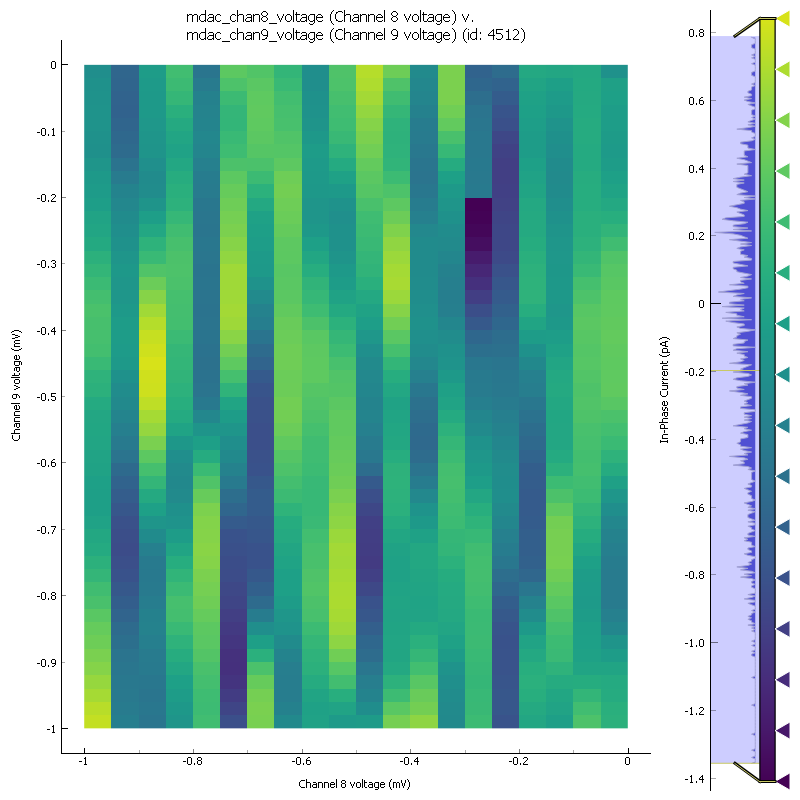

In [10]:
dataid, win = qcm.linear2d(mdac.ch08.voltage, 0, -0.001, 20, 0.1,
                           mdac.ch09.voltage, 0, -0.001, 50, 0.01,
                           lockin.X_current, setback=True)
Image(f"figures\\{dataid}.png", width=600)

#### 2D Traces with Array Parameters
We might want to run traces where the parameter is returned as an array, for example a trace from a scope. We can do this with linear1d.

For example, in the below measurement, we are sweeping the phase of a source being used to do homodyne detection. A sawtooth wave is being applied to the gate of a quantum dot device and is read out using an osciloscope. When the phase of the returned signal matches the LO phase, the slope of the signal on the osciloscope is maximum. When it is out of phase, there is no signal visible.

In order to readout the arrayparameter from the DSO, we need to call `dso.ch1.trace.prepare_curvedata` before we start to get information about the trace on the scope. We do this by passing the optional argument `atstart` to `linear1d` which runs each of the functions given before the measurement.

**Note**: See the docstring for a list of all optional paramters.

dso_Channel1_trace qubit_source_phase
Starting experimental run with id: 4513
Saving to: C:\Users\Administrator\Documents\qcodes_measurements\templates\figures\4513.png


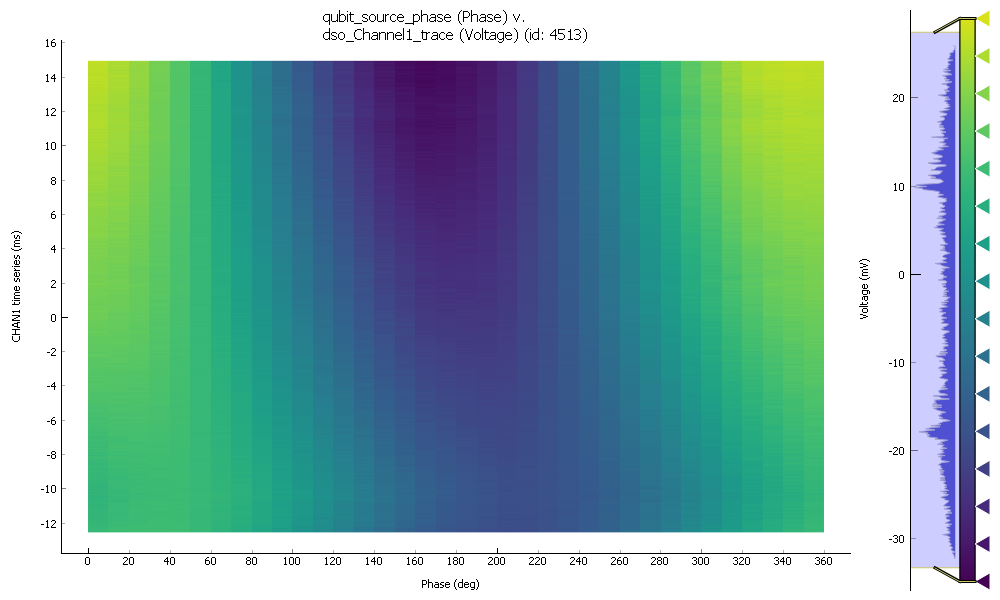

In [12]:
dataid, win = qcm.linear1d(qubit_source.phase, 0, 360, 36, 0.5, dso.ch1.trace, 
                           atstart=(dso.ch1.trace.prepare_curvedata))
Image(f"figures\\{dataid}.png", width=600)

### Running Measurements with MDAC

qcodes_measurements defines a number of helpful functions for running measurements, which figure out whether to ramp or step certain gate voltages, and use MDAC's inbuilt ramp generator to do those things.

It will also append a textbox to the plot with all the gate voltages that are being applied by MDAC.

*TODO*: Fix this to use the gate labels rather than channel numbers...

#### Running 1D Traces
This will open a pyqtgraph window that will stream the data as it comes in. Once the trace is done the figure will be saved to the figures folder and looks like this:

sr860_X_current mdac_chan8_voltage
Starting experimental run with id: 4514
Saving to: C:\Users\Administrator\Documents\qcodes_measurements\templates\figures\4514.png


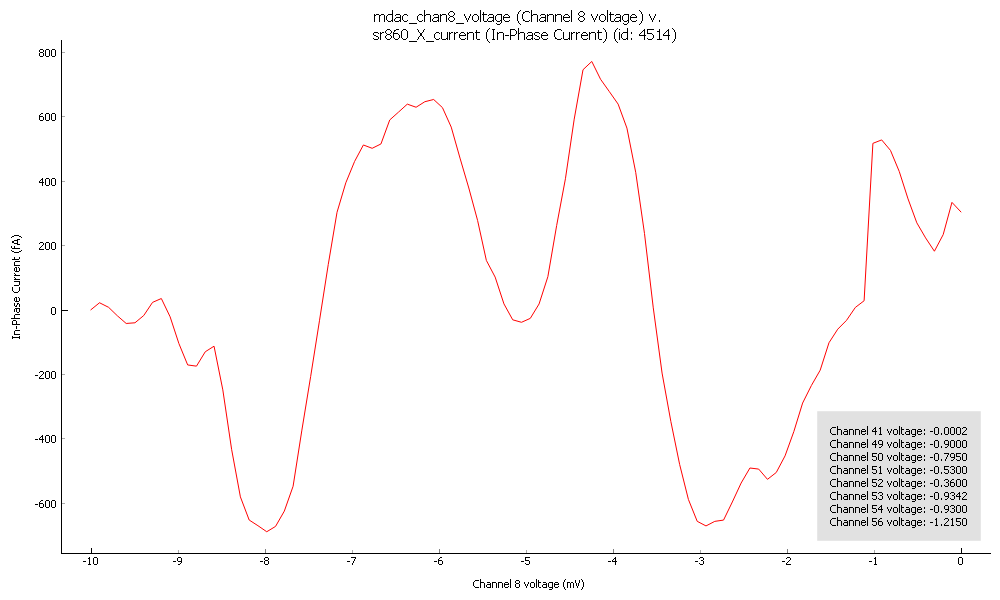

In [13]:
dataid, win = qcm.linear1d_ramp(mdac.ch08.voltage, 0, -0.01, 100, 0.001, lockin.X_current)
Image(f"figures\\{dataid}.png", width=600)

Do the same in 2D. Note that this will ramp the sweep gate back to the starting point each time, rather than setting it straight back. Any additional time that is given in the delay will run AFTER the ramp.

Starting experimental run with id: 4515
Item is a <class 'qcodes_measurements.plot.pyplot.HistogramLUTItem'>
Saving to: C:\Users\Administrator\Documents\qcodes_measurements\templates\figures\4515.png


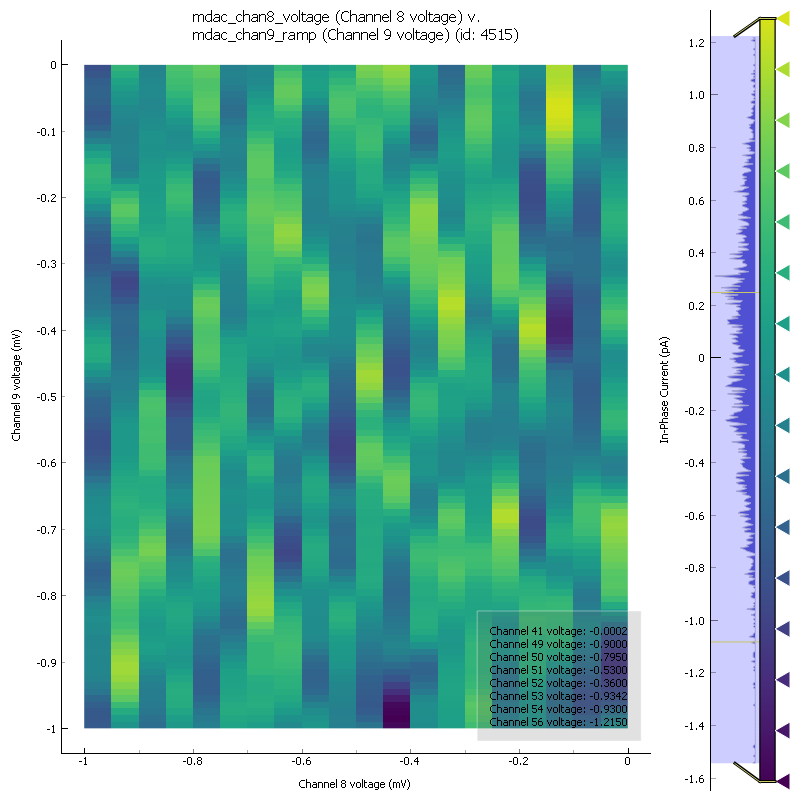

In [14]:
dataid, win = qcm.linear2d_ramp(mdac.ch08.voltage, 0, -0.001, 20, 0.1,
                                mdac.ch09.voltage, 0, -0.001, 100, 0.01,
                                lockin.X_current, rampback=True)
Image(f"figures\\{dataid}.png", width=600)

Note: There are many optional arguments to linear1d, linear2d which can be used to change what the functions do. See the docstring for more information.

#### Useful MDAC Shortcuts

In [15]:
# Ramp a given gate, set up in the yaml file
qcm.ramp(mdac.LW1, -0.1)

# Ramp all gates to zero
GATES.ramp(0)

# Set all filters to 10Hz
GATES.filters(2)

# Ramp EVERYTHING to zero; ground everything
mdac.channels.ramp(0)
while not all(v == 0 for v in mdac.channels.voltage()):
    time.sleep(0.1)
mdac.channels.gnd(0)

### Example of a simple, non wrapped, 1d sweep with v2 dataset
We can manually run sweeps and do live plotting too.

This sweep is equivalent to the example given for `linear1d` above.

Starting experimental run with id: 4520
Saving to: C:\Users\Administrator\Documents\qcodes_measurements\templates\figures\4520.png


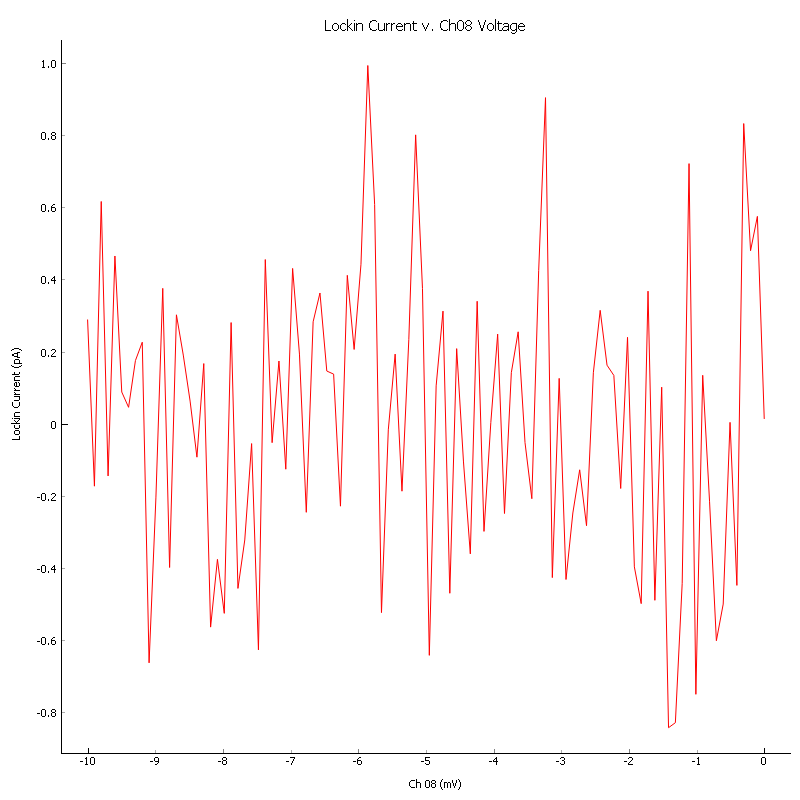

In [19]:
import numpy as np

meas = Measurement()
meas.register_parameter(mdac.ch08.voltage)  # register the first independent parameter
meas.register_parameter(lockin.X_current, setpoints=(mdac.ch08.voltage,))  # now register the dependent one

# Calculate Setpoints, and allocate space to save data
num_points = 100
setpoints = np.linspace(0, -0.01, num_points)
data = np.full(num_points, np.nan)

# Set up a plotting window
win = qcm.pyplot.PlotWindow(title="My Plot Window")
win.resize(800,800)
plot = win.addPlot(title="Lockin Current v. Ch08 Voltage")
plot.plot(setpoint_x=setpoints, pen=(255,0,0)) # Plot in red
plot.left_axis.label = "Lockin Current"; plot.left_axis.units = "A"
plot.bot_axis.label = "Ch 08"; plot.bot_axis.units = "V"

with meas.run() as datasaver:
    for i, set_v in enumerate(setpoints):
        mdac.ch08.voltage(set_v)
        data[i] = lockin.X_current()
        plot.traces[0].update(data)
        datasaver.add_result((mdac.ch08.voltage, set_v),
                             (lockin.X_current, data[i]))
    dataid = datasaver.run_id  # convenient to have for plotting

qcm.plot_tools.save_figure(win, dataid)
Image(f"figures\\{dataid}.png", width=600)